## Lbrerías

In [1]:
import os
from typing import Tuple
import random
from collections import Counter
from PIL import Image

# Pytorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import datasets, transforms

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Hydra
import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import DictConfig
from omegaconf import OmegaConf

# Sklearn
from sklearn.model_selection import train_test_split

# Matplotlib
import matplotlib.pyplot as plt

import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device Name:", torch.cuda.get_device_name(0))

PyTorch version: 2.4.1
CUDA available: True
CUDA version: 11.8
Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Configuración de librerías

In [ ]:
random.seed(42)

## Globales

In [ ]:
GlobalHydra.instance().clear()
hydra.initialize(config_path=".", version_base=None)
cfg = hydra.compose(config_name="config")
print(OmegaConf.to_yaml(cfg))

model:
  learning_rate: 0.003
  batch_size: 32
  epochs: 10
  patience: 3
  train_dataset_dir: data/train
  validation_dataset_dir: data/valid
  test_dataset_dir: data/test
data:
  labeled_percentage: 0.3



In [ ]:
class CustomLoader(pl.LightningDataModule):
    def __init__(self, dataset: Dataset, batch_size=32):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size


    def split(self, labeled_percentage) -> Tuple[Dataset, Dataset]:
        labels = [sample[1] for sample in self.dataset.samples]        
        
        # División estratificada
        labeled_indices, unlabeled_indices = train_test_split \
        (
            range(len(self.dataset)),
            test_size=1 - labeled_percentage,
            stratify=labels
        )

        labeled_subset = Subset(self.dataset, labeled_indices)
        unlabeled_subset = Subset(self.dataset, unlabeled_indices)
        
        labeled_dataset = self.create_dataset_from_subset(labeled_subset)
        unlabeled_dataset = self.create_dataset_from_subset(unlabeled_subset)

        return labeled_dataset, unlabeled_dataset


    def create_dataset_from_subset(self, subset):
        samples = [self.dataset.samples[idx] for idx in subset.indices]
        new_dataset = datasets.ImageFolder(root=self.dataset.root, transform=self.dataset.transform)
        new_dataset.samples = samples
        new_dataset.targets = [sample[1] for sample in samples]  # Actualizar etiquetas
        return new_dataset


    def get_dataloader(self):
        return DataLoader(self.labeled_data, batch_size=self.batch_size, shuffle=True)

## Model

In [ ]:
class UNetAutoencoder(pl.LightningModule):
    def __init__(self, input_channels=3, output_channels=3, learning_rate=1e-3):
        super(UNetAutoencoder, self).__init__()
        self.learning_rate = learning_rate

        # Encoder
        self.enc1 = self.conv_block(input_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # # Decoder
        # self.dec4 = self.upconv_block(1024, 512)
        # self.dec3 = self.upconv_block(512, 256)
        # self.dec2 = self.upconv_block(256, 128)
        # self.dec1 = self.upconv_block(128, 64)

        # Decoder
        self.dec4 = self.upconv_block(1024, 512)
        # Cat
        self.dec3 = self.upconv_block(512 + 512, 256)
        self.dec2 = self.upconv_block(256 + 256, 128)
        self.dec1 = self.upconv_block(128 + 128, 64)


        # Final layer
        self.final_layer = nn.Conv2d(128, output_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential \
        (
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )


    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential \
        (
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
    
    
    def forward(self, x):
        # Encoder
        # print("\nx:", x.shape)  # Muestra las dimensiones de la entrada
        enc1 = self.enc1(x)
        # print("enc1 size:", enc1.shape)  # Muestra las dimensiones después de la primera capa

        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        # print("enc2 size:", enc2.shape)  # Muestra las dimensiones después de la segunda capa

        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        # print("enc3 size:", enc3.shape)  # Muestra las dimensiones después de la tercera capa

        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        # print("enc4 size:", enc4.shape)  # Muestra las dimensiones después de la cuarta capa

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        # print("bottleneck size:", bottleneck.shape)  # Muestra las dimensiones del cuello de botella

        # Decoder with skip connections
        dec4 = self.dec4(bottleneck)
        # print("dec4 size:", dec4.shape)  # Muestra las dimensiones después de la primera capa del decodificador
        dec4 = torch.cat((dec4, enc4), dim=1)
        # print("dec4 after concatenation size:", dec4.shape)  # Después de concatenar

        dec3 = self.dec3(dec4)
        # print("dec3 size:", dec3.shape)  # Muestra las dimensiones después de la segunda capa del decodificador
        dec3 = torch.cat((dec3, enc3), dim=1)
        # print("dec3 after concatenation size:", dec3.shape)  # Después de concatenar

        dec2 = self.dec2(dec3)
        # print("dec2 size:", dec2.shape)  # Muestra las dimensiones después de la tercera capa del decodificador
        dec2 = torch.cat((dec2, enc2), dim=1)
        # print("dec2 after concatenation size:", dec2.shape)  # Después de concatenar

        dec1 = self.dec1(dec2)
        # print("dec1 size:", dec1.shape)  # Muestra las dimensiones después de la cuarta capa del decodificador
        dec1 = torch.cat((dec1, enc1), dim=1)
        # print("dec1 after concatenation size:", dec1.shape)  # Después de concatenar
        
        # Output layer
        output = self.final_layer(dec1)
        # print("Output size:", output.shape)  # Muestra las dimensiones de la salida
        return output


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    def training_step(self, batch, batch_idx):
        inputs, _ = batch  # Ignora las etiquetas
        outputs = self(inputs)
        loss = F.mse_loss(outputs, inputs)
        self.log('train_loss', loss)
        return loss

    
    def test_step(self, batch, batch_idx):
        inputs, _ = batch  # Ignora las etiquetas
        outputs = self(inputs)
        loss = F.mse_loss(outputs, inputs)
        self.log('test_loss', loss)
        return loss

## Clasificadores

In [ ]:
class Classifier_A(pl.LightningModule):
    def __init__(self):
        super(Classifier_A, self).__init__()
        self.model = nn.Sequential
        (
            nn.Flatten(),
            nn.Linear(512, 128),  # Ajusta según sea necesario
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


class Classifier_B(pl.LightningModule):
    def __init__(self, encoder, fine_tune=False):
        super(Classifier_B, self).__init__()
        self.encoder = encoder

        if not fine_tune:
            for param in self.encoder.parameters():
                param.requires_grad = False  # Congelar el encoder si es necesario
        
        self.classifier = nn.Sequential
        (
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


## Samples

In [ ]:
# El dataset no redimensiona las imágenes de forma inmediata al ser cargadas en memoria. Las imágenes se cargan solo cuando accedes a ellas.
# Las transformaciones se aplican cada vez que accedes a una imagen, no al momento de la creación del dataset. Esto significa que la imagen será
# redimensionada solo cuando el dataset realmente cargue la imagen durante el entrenamiento o la evaluación (cuando haces una iteración sobre el dataset).
train_full_dataset = datasets.ImageFolder(root=cfg.model.train_dataset_dir)
test_full_dataset = datasets.ImageFolder(root=cfg.model.test_dataset_dir)

train_species_counts = Counter([sample[1] for sample in train_full_dataset.samples])
top_20_species = [species for species, count in train_species_counts.most_common(20)]

train_samples_from_top_20_species_by_image_count = [sample for sample in train_full_dataset.samples if sample[1] in top_20_species]
test_samples_from_top_20_species_by_image_count = [sample for sample in test_full_dataset.samples if sample[1] in top_20_species]

train_samples = []
test_samples = test_samples_from_top_20_species_by_image_count

for specie in top_20_species:
    species_samples = [sample for sample in train_samples_from_top_20_species_by_image_count if sample[1] == specie] # if sample tag = tag
    random.shuffle(species_samples)
    train_samples.extend(species_samples[:-20])
    test_samples.extend(species_samples[-20:])

print(f'Training samples: {len(train_samples)}')
print(f'Testing samples: {len(test_samples)}')

Training samples: 2546
Testing samples: 500


## Datasets

In [ ]:
transform = transforms.Compose \
(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = datasets.ImageFolder(root=cfg.model.train_dataset_dir, transform=transform)
train_dataset.samples = train_samples

test_dataset = datasets.ImageFolder(root=cfg.model.test_dataset_dir, transform=transform)
test_dataset.samples = test_samples

## Experimento 1

Tome el set de datos de entrenamiento y simule que una parte de cada clase no contiene
labels, denominado set de datos sin labels, el otro restante será denominado set de datos
con labels.

In [ ]:
cl = CustomLoader(dataset=train_dataset, batch_size=cfg.model.batch_size)
set_de_datos_con_labels, set_de_datos_sin_labels = cl.split(labeled_percentage=cfg.data.labeled_percentage)

print(f"Labeled: {len(set_de_datos_con_labels.samples)}")
print(f"Unlabeled: {len(set_de_datos_sin_labels.samples)}")


train_labeled_dl = DataLoader(dataset=set_de_datos_con_labels, batch_size=cfg.model.batch_size, shuffle=True)
train_unlabeled_dl = DataLoader(dataset=set_de_datos_sin_labels, batch_size=cfg.model.batch_size, shuffle=True)


Labeled: 763
Unlabeled: 1783


Utilice el set de datos sin labels para reconstruir las muestras utilizando un Autoencoder
para aprender una representación latente de los datos. El Autoencoder debe estar basado
en la Arquitectura U-Net. Es obligatorio la permanencia de Skip Connections.

In [ ]:
# model = UNetAutoencoder(input_channels=3, output_channels=3, learning_rate=cfg.model.learning_rate)

# trainer = pl.Trainer \
# (
#     max_epochs=cfg.model.epochs,
#     callbacks = \
#     [
#         EarlyStopping \
#         (
#             monitor="train_loss", patience=int(cfg.model.patience), mode="min"
#         )
#     ]
# )


# trainer.fit(model, train_unlabeled_dl)
# trainer.save_checkpoint("UNetAutoencoder_v1_lr_003_e_10.ckpt")

In [ ]:
model = UNetAutoencoder(input_channels=3, output_channels=3, learning_rate=cfg.model.learning_rate)
print(model.enc1[0].weight)


# model = UNetAutoencoder.load_from_checkpoint("UNetAutoencoder.ckpt")
model = UNetAutoencoder.load_from_checkpoint("UNetAutoencoder_v1_lr_003_e_10.ckpt")
print("-------------------------------------------------------------")


print(model.enc1[0].weight)

Parameter containing:
tensor([[[[ 0.0409, -0.0516, -0.1245],
          [-0.0869,  0.0080, -0.0499],
          [ 0.0996, -0.0360,  0.0753]],

         [[ 0.0975,  0.0293, -0.1370],
          [-0.0793,  0.0263, -0.1715],
          [ 0.0577,  0.0585, -0.0777]],

         [[-0.0837,  0.1137,  0.1456],
          [-0.1752, -0.1554,  0.0209],
          [-0.1048, -0.0218, -0.0724]]],


        [[[-0.0537, -0.0635,  0.0472],
          [-0.0428, -0.1121,  0.0916],
          [-0.0857, -0.0171, -0.0748]],

         [[-0.0679,  0.0995, -0.1203],
          [ 0.0226,  0.0889, -0.1724],
          [-0.0942, -0.1331, -0.0989]],

         [[-0.1319,  0.0198, -0.1518],
          [-0.1877, -0.0717, -0.0277],
          [-0.1570,  0.0005, -0.1727]]],


        [[[ 0.1257, -0.1604, -0.1722],
          [ 0.0947, -0.1682,  0.1177],
          [-0.0705, -0.0833,  0.0557]],

         [[ 0.1738,  0.0771, -0.1872],
          [ 0.1136,  0.1004, -0.1121],
          [-0.1028, -0.0750, -0.1529]],

         [[ 0.0327, -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


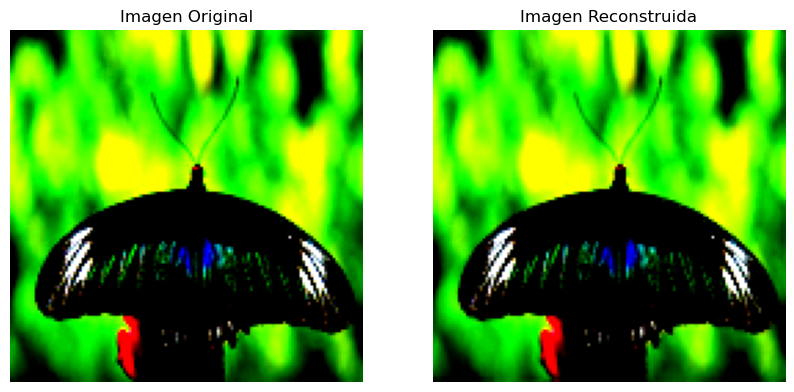

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

data_iter = iter(train_unlabeled_dl)
images, labels = next(data_iter)
images = images.to(device)

with torch.no_grad():
    reconstructed_images = model(images)

original_image = images[0].cpu().detach().numpy().transpose(1, 2, 0)
reconstructed_image = reconstructed_images[0].cpu().detach().numpy().transpose(1, 2, 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title("Imagen Reconstruida")
plt.axis('off')

plt.show()
